# Portuguese Red Wine Quality Ratings 
### Visualising in Plotly and Bokeh, Modelling in Tensorflow and Keras

## Imports

#### General

In [5]:
import pandas as pd
import numpy as np
import os
from math import pow
from math import log
import random as rd
from scipy.stats.kde import gaussian_kde
import colorcet as cc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

#### Plotly

In [6]:
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML
import plotly.graph_objs as go

#### Bokeh

In [7]:
import bokeh.plotting as bplt
from bokeh.plotting import gmap
from bokeh.io import output_notebook, show, output_file, push_notebook
from bokeh.models import NumeralTickFormatter, ColumnDataSource, HoverTool, CustomJS, Slider, GMapOptions, Toggle, LinearAxis, Range1d
from bokeh.models.callbacks import CustomJS
from bokeh.layouts import row, column
from bokeh.palettes import Category20_16, Category20_20
from bokeh.models.widgets import CheckboxGroup, Slider, Dropdown

#### Keras

In [8]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

C:\Users\Luke\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


#### Tensorflow

In [9]:
# Import Libraries
import torch
import torch.nn
import torch.utils.data as utils_data
from torch import optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import functional as F

## Exploring the Data

In [10]:
df2=pd.read_csv('winequality-red.csv')
df2.head()
df2.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
df2.isnull().values.any()
df2.isna().values.any()

False

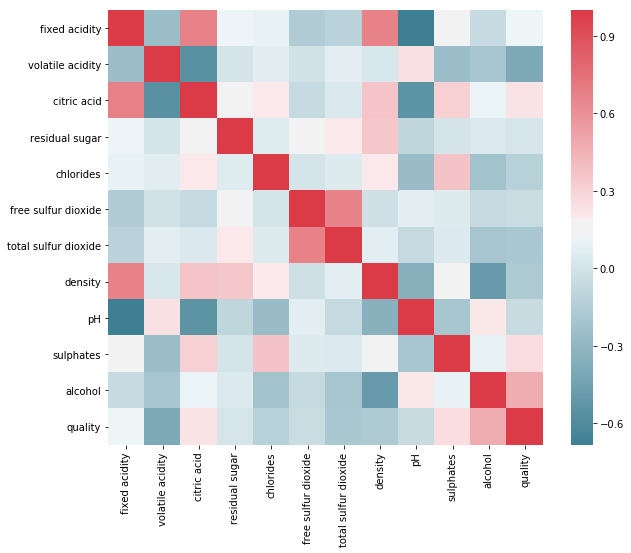

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr2 = df2.corr()
sns.heatmap(corr2, mask=np.zeros_like(corr2, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [13]:
corr2.style.background_gradient().set_precision(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.26,0.67,0.11,0.094,-0.15,-0.11,0.67,-0.68,0.18,-0.062,0.12
volatile acidity,-0.26,1,-0.55,0.0019,0.061,-0.011,0.076,0.022,0.23,-0.26,-0.2,-0.39
citric acid,0.67,-0.55,1,0.14,0.2,-0.061,0.036,0.36,-0.54,0.31,0.11,0.23
residual sugar,0.11,0.0019,0.14,1,0.056,0.19,0.2,0.36,-0.086,0.0055,0.042,0.014
chlorides,0.094,0.061,0.2,0.056,1,0.0056,0.047,0.2,-0.27,0.37,-0.22,-0.13
free sulfur dioxide,-0.15,-0.011,-0.061,0.19,0.0056,1,0.67,-0.022,0.07,0.052,-0.069,-0.051
total sulfur dioxide,-0.11,0.076,0.036,0.2,0.047,0.67,1,0.071,-0.066,0.043,-0.21,-0.19
density,0.67,0.022,0.36,0.36,0.2,-0.022,0.071,1,-0.34,0.15,-0.5,-0.17
pH,-0.68,0.23,-0.54,-0.086,-0.27,0.07,-0.066,-0.34,1,-0.2,0.21,-0.058
sulphates,0.18,-0.26,0.31,0.0055,0.37,0.052,0.043,0.15,-0.2,1,0.094,0.25


In [14]:
train2, validate2, test2 = np.split(df2.sample(frac=1), [int(.65*len(df2)), int(.80*len(df2))])

In [15]:
def exclude_quality(df):
    return(df.columns[~df.columns.isin(['quality'])])

wo_quality = exclude_quality(train2)
x_train2, x_validate2, x_test2 = train2[wo_quality], validate2[wo_quality], test2[wo_quality]
y_train2, y_validate2, y_test2 = train2['quality'], validate2['quality'], test2['quality']

print('Number of columns in data: ', train2.shape[1]-1)
print('Size of training set: ', train2.shape[0])
print('Size of validation set: ', validate2.shape[0])
print('Size of test set: ', test2.shape[0])

Number of columns in data:  11
Size of training set:  1039
Size of validation set:  240
Size of test set:  320


In [16]:
min_max_scaler = MinMaxScaler()
x_train_mnmx2 = pd.DataFrame(min_max_scaler.fit_transform(x_train2.values))
x_validate_mnmx2 = pd.DataFrame(min_max_scaler.fit_transform(x_validate2.values))
x_test_mnmx2 = pd.DataFrame(min_max_scaler.fit_transform(x_test2.values))

means2 = x_train2.append(x_validate2, ignore_index=True).mean(axis=0)
stds2 = x_train2.append(x_validate2, ignore_index=True).std(axis=0)
x_train_zscore2 = pd.DataFrame()
cols2 = df2.columns.values.tolist()
for c in cols2[:(len(cols2)-1)]:
    x_train_zscore2[c] = (x_train2[c]-means2[c])/stds2[c]
x_validate_zscore2 = pd.DataFrame()
for c in cols2[:(len(cols2)-1)]:
    x_validate_zscore2[c] = (x_validate2[c]-means2[c])/stds2[c]

## Plotly

In [17]:
init_notebook_mode(connected=True)

In [22]:
dataPoints = go.Scattergl(
    x=df2['sulphates'],
    y=df2['alcohol'],
    mode='markers',
    marker=dict(
        opacity=0.75,
        color=df2.quality,
        showscale=True,
        colorscale='Jet',
        colorbar=dict(
            title='Quality'
        ),
    ),
    name='Data points'
)

data=[dataPoints]

layout = go.Layout(
    title='Quality vs Alcohol and Sulphates',
    xaxis=dict(
        title='sulphates'.title()
    ),
    yaxis=dict(
        title='alcohol'.title()
    ),
    #showlegend=True
)

figure = go.Figure(data=data, layout=layout)

iplot(figure, show_link=False)

In [23]:
dataPoints = go.Scattergl(
    x=df2['volatile acidity'],
    y=df2['citric acid'],
    mode='markers',
    marker=dict(
        opacity=0.75,
        color=df2.quality,
        showscale=True,
        colorscale='Jet',
        colorbar=dict(
            title='Quality'
        ),
    ),
    name='Data points'
)

data=[dataPoints]

layout = go.Layout(
    title='Colored Scatterplot',
    xaxis=dict(
        title='volatile acidity'.title()
    ),
    yaxis=dict(
        title='citric acid'.title()
    ),
    #showlegend=True
)

figure = go.Figure(data=data, layout=layout)

iplot(figure)

In [24]:
data = []
labels = np.sort(df2.quality.unique())
for lab in labels:
    col = "rgb(%s,%s,%s)" %(rd.randint(10,255),rd.randint(10,255),rd.randint(10,255))
    data.append(go.Box(
        y=df2['pH'][df2['quality']==lab],
        name=str(lab).title(),
        marker=dict(
            color=col,
        ),
        boxmean=True))

layout = go.Layout(
    title='Boxplot of Quality vs pH',
    xaxis=dict(
        title='Quality'.title()
    ),
    yaxis=dict(
        title='pH'.title()
    ),
    #showlegend=True
)

figure = go.Figure(data=data, layout=layout)

iplot(figure, show_link=False)

# PyTorch

In [25]:
# Create random Tensors to hold inputs and outputs
x = torch.from_numpy(x_train_mnmx2.values).float()
x_val = torch.from_numpy(x_validate_mnmx2.values).float()
x_z = torch.from_numpy(x_train_zscore2.values).float()
x_val_z = torch.from_numpy(x_validate_zscore2.values).float()
y = torch.from_numpy(y_train2.values.reshape(-1,1)).float()
y_val = torch.from_numpy(y_validate2.values.reshape(-1,1)).float()

In [26]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, D_out = 11, 1
H = 40

# Use the nn package to define our model and loss function.
torch_model1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 0.001
optimizer = torch.optim.RMSprop(torch_model1.parameters(), lr=learning_rate)
train_loss1 = []
val_loss1 = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_val = Variable(torch_model1(x_val), requires_grad = False)
    mse = 0
    for i in range(y_validate2.shape[0]):
        mse += pow(y_validate2.tolist()[i] - y_pred_val.numpy()[i][0],2)
    mse=mse/y_validate2.shape[0]
    val_loss1.append(mse)
    
    y_pred = torch_model1(x)
    
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss1.append(loss.item())
    print(t, loss.item(), mse)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 30.82880210876465 30.28156845207411
1 28.354280471801758 27.816465320976715
2 26.695722579956055 26.16494452867483
3 25.38709831237793 24.86222233153618
4 24.28293228149414 23.76323425101993
5 23.316041946411133 22.801006202722636
6 22.449148178100586 21.938376250590828
7 21.65914535522461 21.152322759258315
8 20.930612564086914 20.427482487579628
9 20.2526798248291 19.753030302522113
10 19.617355346679688 19.121008694058197
11 19.018571853637695 18.525376844273783
12 18.451597213745117 17.96142256088803
13 17.91265296936035 17.425389439348127
14 17.398683547973633 16.91423356838046
15 16.907163619995117 16.425446216077543
16 16.43599510192871 15.956935807025404
17 15.983402252197266 15.506941305963407
18 15.547876358032227 15.073961024393009
19 15.128125190734863 14.656709439014064
20 14.72302532196045 14.254071316484861
21 14.3316011428833 13.865076755050564
22 13.952990531921387 13.488871122797075
23 13.586435317993164 13.124698575576467
24 13.231258392333984 12.77188856086187
25 

206 0.6759148240089417 0.5884864517560724
207 0.6754669547080994 0.5885031411011321
208 0.6750367879867554 0.5885252141021643
209 0.6746233105659485 0.5885517549170071
210 0.6742255687713623 0.5885821122112834
211 0.6738425493240356 0.5886155461619761
212 0.6734732985496521 0.588651407800315
213 0.6731170415878296 0.5886891015849983
214 0.6727728843688965 0.5887280086277987
215 0.6724401116371155 0.5887676036332541
216 0.6721179485321045 0.5888075366071888
217 0.6718056797981262 0.5888472125526392
218 0.6715027689933777 0.5888862576724667
219 0.6712085008621216 0.5889243584628048
220 0.6709222793579102 0.5889610673770562
221 0.6706436276435852 0.5889960587221964
222 0.670371949672699 0.5890292536808801
223 0.670106828212738 0.5890600828264136
224 0.6698477864265442 0.5890884257380417
225 0.6695943474769592 0.5891142510296513
226 0.6693460941314697 0.5891370808215289
227 0.6691027283668518 0.5891567974343975
228 0.6688637733459473 0.5891734362675237
229 0.6686290502548218 0.589186629842

407 0.6246724724769592 0.5576087427544584
408 0.6243540048599243 0.5573472977436182
409 0.6240346431732178 0.557085375622062
410 0.6237144470214844 0.5568228551027516
411 0.6233934164047241 0.5565596652923053
412 0.6230714917182922 0.5562961207216953
413 0.6227487921714783 0.5560319224516993
414 0.6224251389503479 0.5557670475464458
415 0.6221007108688354 0.5555017184949729
416 0.6217754483222961 0.5552358564251638
417 0.6214492917060852 0.5549693261105716
418 0.6211223602294922 0.5547023485024322
419 0.6207944750785828 0.5544347799968022
420 0.620465874671936 0.5541665274662193
421 0.6201363801956177 0.5538979409174061
422 0.6198060512542725 0.553628674429973
423 0.6194748878479004 0.5533589477645506
424 0.6191428303718567 0.5530886730764252
425 0.6188099980354309 0.5528177070396946
426 0.6184763312339783 0.5525463919197231
427 0.6181418895721436 0.5522743509912194
428 0.6178064942359924 0.5520019609769861
429 0.617470383644104 0.5517289061907983
430 0.617133378982544 0.55145543014129

In [27]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, D_out = 11, 1
H1,H2,H3 = 100, 50, 20

# Use the nn package to define our model and loss function.
torch_model2 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H3, D_out),
)
loss_fn2 = torch.nn.MSELoss(reduction='elementwise_mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 0.01
optimizer2 = torch.optim.Adam(torch_model2.parameters(), lr=learning_rate)
train_loss2 = []
val_loss2 = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_val = Variable(torch_model2(x_val), requires_grad = False)
    mse = 0
    for i in range(y_validate2.shape[0]):
        mse += pow(y_validate2.tolist()[i] - y_pred_val.numpy()[i][0],2)
    mse=mse/y_validate2.shape[0]
    val_loss2.append(mse)
    
    if (len(val_loss2)>30):
        if np.mean(val_loss2[(t-5):t]) > np.mean(val_loss2[(t-25):(t-20)]):
            break
        
    y_pred = torch_model2(x)
    
    # Compute and print loss.
    loss = loss_fn2(y_pred, y)
    train_loss2.append(loss.item())
    print(t, loss.item(), mse)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer2.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer2.step()

0 32.39857482910156 31.78986212136743
1 30.611122131347656 29.991457759280312
2 28.630565643310547 28.00689823823445
3 26.25684356689453 25.598611652608714
4 23.44435691833496 22.813592270696397
5 20.36012077331543 19.74266745026667
6 17.404582977294922 16.84943157984464
7 15.030662536621094 14.53808135030002
8 13.369095802307129 12.954753075191274
9 12.207035064697266 11.827256961853493
10 11.266425132751465 10.906798779384731
11 10.413688659667969 10.068756148897531
12 9.610929489135742 9.27923361879441
13 8.849119186401367 8.530184274566926
14 8.12691879272461 7.820583319132738
15 7.4442219734191895 7.150362295450989
16 6.800966739654541 6.519448310136298
17 6.1969380378723145 5.9276128046239664
18 5.6317524909973145 5.374455753949026
19 5.104849815368652 4.859402052537482
20 4.615516662597656 4.381721728255313
21 4.162891387939453 3.94053905831688
22 3.745980739593506 3.534845041220072
23 3.363665819168091 3.163506620753166
24 3.014716863632202 2.825280616357183
25 2.69780278205871

In [28]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, D_out = 11, 1
H1,H2,H3,H4 = 80, 120, 20, 10

class Mod3(torch.nn.Module):
    def __init__(self):
        super(Mod3, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, H3)
        self.linear4 = torch.nn.Linear(H3, H4)
        self.linear5 = torch.nn.Linear(H4, D_out)

    def forward(self, x):
        layer1_out = torch.tanh(self.linear1(x))
        layer1_drp = F.dropout(layer1_out, training=True, p=0.2)
        layer2_out = F.relu(self.linear2(layer1_drp))
        layer2_drp = F.dropout(layer2_out, training=True, p=0.1)
        layer3_out = F.relu(self.linear3(layer2_drp))
        layer3_drp = F.dropout(layer3_out, training=True, p=0.1)
        layer4_out = F.relu(self.linear4(layer3_drp))
        out = self.linear5(layer4_out)
        return out, layer1_out, layer2_out, layer3_out, layer4_out

lambda1, lambda2 = 0.01, 0.01
torch_model3 = Mod3()
loss_fn3 = torch.nn.MSELoss(reduction='elementwise_mean')
learning_rate = 0.1
optimizer3 = torch.optim.Adam(torch_model3.parameters(), lr=learning_rate)#, weight_decay=0.01) #l2
train_loss3 = []
val_loss3 = []

for t in range(500):
    y_pred_val = Variable(torch_model3(x_val)[0], requires_grad = False)
    mse = 0
    for i in range(y_validate2.shape[0]):
        mse += pow(y_validate2.tolist()[i] - y_pred_val.numpy()[i][0],2)
    mse=mse/y_validate2.shape[0]
    val_loss3.append(mse)
    
    if (len(val_loss3)>30):
        if np.mean(val_loss3[(t-5):t]) > np.mean(val_loss3[(t-25):(t-20)]):
            break
            
    optimizer3.zero_grad()
    
    y_pred, layer1_out, layer2_out, layer3_out, layer4_out = torch_model3(x)
    Train_MSE = loss_fn3(y_pred, y)
    train_loss3.append(Train_MSE.item())
    print(t, Train_MSE.item(), mse)
    
    #lin1_parameters = torch.cat([x.view(-1) for x in torch_model3.linear2.parameters()])
    #lin2_parameters = torch.cat([x.view(-1) for x in torch_model3.linear3.parameters()])
    l1_reg1 = lambda1 * torch.norm(layer1_out, 1)
    l2_reg1 = lambda2 * torch.norm(layer2_out, 2)
    l1l2_reg1 = ((lambda1*torch.norm(layer3_out, 1))+ (lambda2*torch.norm(layer3_out, 2)))*0.5
    l1l2_reg2 = ((lambda1*torch.norm(layer4_out, 1))+ (lambda2*torch.norm(layer4_out, 2)))*0.5
    
    # add regularization penalties to loss
    loss = Train_MSE + l1_reg1 + l2_reg1 + l1l2_reg1 + l1l2_reg2

    loss.backward()

    optimizer3.step()

0 35.281612396240234 34.65170269448568
1 33.68553924560547 33.08548475970785
2 32.50501251220703 31.915055633858056
3 31.388412475585938 30.808178918964696
4 30.293062210083008 29.72253997149877
5 29.219240188598633 28.65841638183696
6 28.16721534729004 27.616074799029963
7 27.137248992919922 26.59576472843436
8 26.129566192626953 25.597712258277106
9 25.14436912536621 24.62212183388831
10 24.181848526000977 23.669171235582365
11 23.24215316772461 22.739012194333075
12 22.325416564941406 21.83177041780514
13 21.43173599243164 20.947542422728716
14 20.561189651489258 20.086398070543865
15 19.71381378173828 19.248378739337905
16 18.889629364013672 18.433495295569536
17 18.088621139526367 17.641731347376258
18 17.31075096130371 16.873042817522087
19 16.55594825744629 16.127355797774605
20 15.824110984802246 15.404568489248657
21 15.115118026733398 14.704552129784105
22 14.428814888000488 14.027151063278385
23 13.765022277832031 13.372182101013983
24 13.12353515625 12.739439126708445
25 12

Visualise all three models development

In [29]:
trace1 = go.Scatter(
    x=[i for i in range(len(train_loss1))],
    y=train_loss1,
    name='Model 1 Training',
    line=dict(color="green")
)
trace2 = go.Scatter(
    x=[i for i in range(len(train_loss1))],
    y=val_loss1,
    name='Model 1 Validation',
    line=dict(color="lightgreen")
)
trace3 = go.Scatter(
    x=[i for i in range(len(train_loss2))],
    y=train_loss2,
    name='Model 2 Training',
    line=dict(color="blue")
)
trace4 = go.Scatter(
    x=[i for i in range(len(train_loss2))],
    y=val_loss2,
    name='Model 2 Validation',
    line=dict(color="lightblue")
)
trace5 = go.Scatter(
    x=[i for i in range(len(train_loss3))],
    y=train_loss3,
    name='Model 3 Training',
    line=dict(color="gray")
)
trace6 = go.Scatter(
    x=[i for i in range(len(train_loss3))],
    y=val_loss3,
    name='Model 3 Validation',
    line=dict(color="lightgray")
)

data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(
    title='Wine Quality Model Performance',
    yaxis=dict(
        title='Mean Squared Error'
    ),
    xaxis=dict(
        title='Epoch'
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Then visualise predictions of best one vs actual

In [30]:
new_x_train2 = x_train_mnmx2.append(x_validate_mnmx2,ignore_index=True)
new_y_train2 = y_train2.append(y_validate2,ignore_index=True)
new_x = torch.from_numpy(new_x_train2.values).float()
xtest = torch.from_numpy(x_test_mnmx2.values).float()
new_y = torch.from_numpy(new_y_train2.values.reshape(-1,1)).float()
ytest = torch.from_numpy(y_test2.values.reshape(-1,1)).float()

In [31]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, D_out = 11, 1
H = 40

# Use the nn package to define our model and loss function.
torch_model4 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 0.001
optimizer = torch.optim.RMSprop(torch_model4.parameters(), lr=learning_rate)
train_loss4 = []
test_loss4 = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_test = Variable(torch_model4(xtest), requires_grad = False)
    mse = 0
    for i in range(y_test2.shape[0]):
        mse += pow(y_test2.tolist()[i] - y_pred_test.numpy()[i][0],2)
    mse=mse/y_validate2.shape[0]
    test_loss4.append(mse)
    
    y_pred = torch_model4(new_x)
    
    # Compute and print loss.
    loss = loss_fn(y_pred, new_y)
    train_loss4.append(loss.item())
    print(t, loss.item(), mse)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 27.486711502075195 36.139271321666804
1 24.91324806213379 32.74081842425863
2 23.20526885986328 30.485531371612954
3 21.8691463470459 28.721436192175922
4 20.750791549682617 27.245005462046826
5 19.779211044311523 25.962468735031507
6 18.915016174316406 24.82178980247978
7 18.133737564086914 23.79065052961098
8 17.41898536682129 22.847395547595656
9 16.759157180786133 21.97669501354941
10 16.14568519592285 21.16722928981924
11 15.572028160095215 20.410359203554176
12 15.033061981201172 19.699311326242693
13 14.524678230285645 19.02865892538627
14 14.043525695800781 18.393973416389425
15 13.586828231811523 17.791587469778065
16 13.152253150939941 17.218419595028955
17 12.737825393676758 16.67185829434406
18 12.34184741973877 16.149661953808238
19 11.962854385375977 15.649896220370282
20 11.599567413330078 15.170868756148122
21 11.250864028930664 14.711099046324907
22 10.915755271911621 14.26927938547694
23 10.59335994720459 13.844244424127217
24 10.282891273498535 13.434956743104616
2

208 0.6678820252418518 0.7873223090521653
209 0.6676036715507507 0.7870419143213297
210 0.66733318567276 0.786771670366367
211 0.6670700311660767 0.7865107471777094
212 0.6668136119842529 0.7862586046036891
213 0.6665635704994202 0.7860146438948088
214 0.6663194298744202 0.7857781858508824
215 0.6660807728767395 0.7855488487790533
216 0.6658471822738647 0.7853261106253048
217 0.665618360042572 0.7851093695039633
218 0.6653938889503479 0.784898259038574
219 0.6651735305786133 0.7846924367421252
220 0.6649568676948547 0.7844913106411308
221 0.6647437214851379 0.7842946736945644
222 0.6645337343215942 0.7841022027801624
223 0.6643266677856445 0.7839134393803591
224 0.6641223430633545 0.7837281379378964
225 0.6639204621315002 0.7835460078694392
226 0.6637208461761475 0.783366809880395
227 0.663523256778717 0.7831902010637027
228 0.6633275747299194 0.7830159746428847
229 0.6631335616111755 0.7828439973146374
230 0.6629411578178406 0.7826739711724912
231 0.6627500653266907 0.7825057838214718

413 0.6197978854179382 0.7449684513014063
414 0.6194903254508972 0.7446988161814166
415 0.6191819906234741 0.7444285274450143
416 0.6188728213310242 0.7441574896416909
417 0.6185628771781921 0.7438858334034307
418 0.6182520985603333 0.7436134906281874
419 0.6179405450820923 0.7433404566013233
420 0.6176282167434692 0.7430667160519439
421 0.6173150539398193 0.742792261302435
422 0.6170011162757874 0.7425172205799678
423 0.6166864037513733 0.7422413400600002
424 0.6163709163665771 0.7419648812918344
425 0.6160545945167542 0.7416877530129521
426 0.6157374978065491 0.7414098795457884
427 0.6154195666313171 0.7411313352722289
428 0.6151009202003479 0.7408520948896069
429 0.6147814989089966 0.740572246455513
430 0.6144612431526184 0.7402917161992045
431 0.6141402721405029 0.7400104343583697
432 0.6138184070587158 0.7397285696979651
433 0.6134958863258362 0.7394459723041545
434 0.6131725311279297 0.7391627211298906
435 0.6128484010696411 0.7388788268811557
436 0.6125234961509705 0.73859427244

In [32]:
y_pred_test = Variable(torch_model4(xtest), requires_grad = False)
y_pred_test = [i[0] for i in y_pred_test.numpy().tolist()]

In [33]:
dataPoints = go.Scattergl(
    x=y_pred_test,
    y=y_test2,
    mode='markers',
    name='Data points'
)

data=[dataPoints]

layout = go.Layout(
    title='Actual Wine Quality Ratings vs Predicted Ratings',
    xaxis=dict(
        title='Predicted Score',
        range=[3, 8]
    ),
    yaxis=dict(
        title='Actual Score'
    ),
    #showlegend=True
)

figure = go.Figure(data=data, layout=layout)

iplot(figure)

What is the MSE of a model which just always predicts the mean?

In [34]:
bad_model_prediction = y_train2.mean(axis=0)
index = y_validate2.index.values
MSE = 0
no_obs = y_validate2.shape[0]
for i in range(no_obs):
    MSE += pow(y_validate2[index[i]]-bad_model_prediction,2)
MSE = MSE/no_obs
MSE

0.6340384222879092

In [35]:
print(y_train2.mean(axis=0), y_validate2.mean(axis=0), y_test2.mean(axis=0))

5.648700673724735 5.6 5.621875


## Keras

Set up Bokeh

In [36]:
output_notebook()

Loading BokehJS ...

In [37]:
# Styling for a plot
def style(p):
    # Title 
    p.title.align = 'center'
    p.title.text_font_size = '20pt'
    p.title.text_font = 'serif'

    # Axis titles
    p.xaxis.axis_label_text_font_size = '14pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_style = 'bold'

    # Tick labels
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    return p

In [38]:
def model3(x_size, y_size):
    model = Sequential()
    model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    model.add(Dropout(0.2))
    model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    model.add(Dense(y_size))
    model.compile(loss='mean_squared_error',optimizer='nadam',metrics=[metrics.mae])
    return(model)

In [39]:
epochs = 500
batch_size = 128
print('Epochs: ', epochs)
print('Batch size: ', batch_size)

Epochs:  500
Batch size:  128


In [40]:
wine_model = model3(new_x_train2.shape[1], 1)
epochs = 500
batch_size = 128
history_wine = wine_model.fit(new_x_train2.values, new_y_train2.values,batch_size=batch_size,epochs=epochs,
                              shuffle=True,verbose=0,validation_data=(x_test_mnmx2.values, y_test2.values),
                  callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)])

In [41]:
training_score = wine_model.evaluate(new_x_train2, new_y_train2, verbose=0)
validation_score = wine_model.evaluate(x_test_mnmx2, y_test2, verbose=0)
print('Keras Wine Model Trained on Training and Validation Datasets')
print('Training MAE: %s\nTraining (Squared) Loss: %s\nValidation MAE: %s\nValidation (Squared) Loss: %s\n'\
      %(training_score[1],training_score[0], 
        validation_score[1],validation_score[0]))

Keras Wine Model Trained on Training and Validation Datasets
Training MAE: 0.5236020108234891
Training (Squared) Loss: 0.7919899643259742
Validation MAE: 0.5508235394954681
Validation (Squared) Loss: 0.8016687035560608



In [42]:
p = bplt.figure(plot_width=900,title="Keras Wine Model Performance Using Validation and Training Data",
           x_axis_label = 'Epoch', y_axis_label = "Mean Absolute Error")

perf_wine = pd.DataFrame(
    {'training': [i for i in history_wine.history['mean_absolute_error']],
     'validation': [i for i in history_wine.history['val_mean_absolute_error']],
     'epoch': [i for i in range(len(history_wine.history['val_mean_absolute_error']))],
    })
source_perf_wine = ColumnDataSource(perf_wine)

p.line('epoch','training',line_width=2, color='purple', legend="Training", source=source_perf_wine)
p.line('epoch','validation',line_width=2, color='blue', legend="Test", source=source_perf_wine)
h = HoverTool(tooltips=[('Train MAE ($k)', '@training'),('Test MAE ($k)', '@validation'),('Epoch', '@epoch')])
p.add_tools(h)
p.legend.location = "top_right"
p.legend.click_policy="hide"
style(p)
show(p)

In [43]:
test_y_predictions = wine_model.predict(x_test_mnmx2)
pred_pd = pd.DataFrame(
    {'predicted': [i[0] for i in test_y_predictions.tolist()],
     'actual': [i for i in y_test2],
    })
source_pred = ColumnDataSource(pred_pd)
p = bplt.figure(plot_width=900,title="Actual Wine Quality Ratings vs Predicted Ratings",\
           x_axis_label = "Predicted Wine Scores", y_axis_label = 'Actual Scores', x_range=[3,8])
p.scatter(x='predicted', y='actual', source=source_pred)
h = HoverTool(tooltips=[('Actual Rating', '@actual'),('Predicted Rating', '@predicted')])
p.add_tools(h)
style(p)
show(p)